In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/Research_Internship/heart.csv'

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Research_Internship/heart.csv')

In [ ]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52,1,1,118,186,0,2,190,0,0.0,2,0,fixed,0
299,43,0,4,132,341,1,2,136,1,3.0,2,0,reversible,1
300,65,1,4,135,254,0,2,127,0,2.8,2,1,reversible,1
301,48,1,4,130,256,1,2,150,1,0.0,1,2,reversible,1


In [ ]:
# Encode categorical variables
data = pd.get_dummies(data, columns=['cp', 'restecg', 'slope', 'thal'])

In [ ]:
# Feature scaling
scaler = StandardScaler()
features = data.drop('target', axis=1)
features_scaled = scaler.fit_transform(features)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, data['target'], test_size=0.2, random_state=42)

# The choice of a Recurrent Neural Network (RNN) for predicting heart disease is driven by several key considerations:

1. Sequential Data Handling: RNNs are inherently designed to process sequential data, making them suitable for analyzing time-series data such as patient vitals and medical history, which are critical in heart disease prediction.

2. Temporal Dependencies: The ability of RNNs to capture temporal dependencies allows the model to understand trends and patterns over time, which are essential for accurate predictions in medical data.

3. Model Architecture: The chosen architecture is simple yet powerful, consisting of an RNN layer for feature extraction followed by a fully connected layer for classification. This ensures efficient training and effective performance.

4. Feature Extraction and Integration: The RNN layer dynamically processes sequential input, extracting relevant features, while the fully connected layer integrates these features to provide the final prediction.

5. Flexibility and Scalability: The model's parameters, such as input size, hidden size, number of layers, and number of classes, are adjustable, allowing for adaptability to different datasets and requirements. The architecture can be scaled to handle more complex data if needed.

In [ ]:
# Define the RNN model
class HeartDiseaseRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(HeartDiseaseRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
num_classes = 2
num_epochs = 50
batch_size = 32
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HeartDiseaseRNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Data loader
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)

        outputs = model(features.unsqueeze(1))  # Add sequence dimension
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.3509
Epoch [20/50], Loss: 0.1489
Epoch [30/50], Loss: 0.3404
Epoch [40/50], Loss: 0.3011
Epoch [50/50], Loss: 0.1294


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_data = torch.tensor(X_test, dtype=torch.float32).to(device)
    test_labels = torch.tensor(y_test.values, dtype=torch.long).to(device)
    outputs = model(test_data.unsqueeze(1))
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == test_labels).sum().item() / test_labels.size(0)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 83.61%


When the plot is displayed, it provides a clear visualization of the model's performance by showing the number of true positives, true negatives, false positives, and false negatives, along with their corresponding labels ('No Disease' and 'Disease').

This visualization helps in understanding how well the model is performing in distinguishing between the two classes and identifying areas where the model might need improvement.








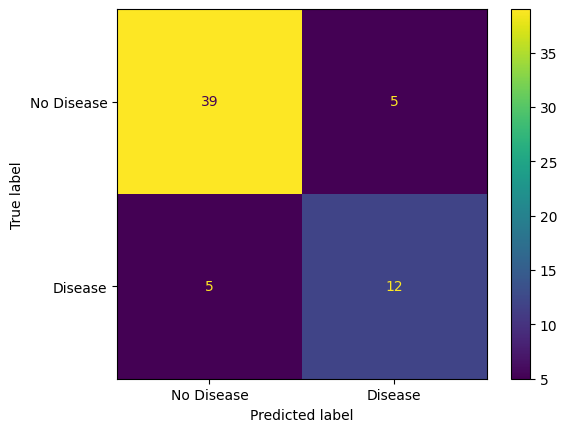

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(test_labels.cpu(), predicted.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
disp.plot()
plt.show()